In [1]:
import datetime

starttime = datetime.datetime.now()

import numpy as np
import os
import cv2
import sklearn.model_selection as ms
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [2]:
# 数据读取

X = []
Y = []
path = os.listdir(r'C:\\Users\\Administrator\\Desktop\\classification\\originals')
classes = {'benign':0, 'malignant':1}
for cls in classes:
    pth = r'C:\\Users\\Administrator\\Desktop\\classification\\originals\\'+cls
    for j in os.listdir(pth):
        img = cv2.imread(pth+'/'+j, 0)
        img = cv2.resize(img, (200,200))
#         img = img.reshape(1,-1)/255
        X.append(img)
        Y.append(classes[cls])

In [3]:
X = np.array(X)
Y = np.array(Y)

# 数据处理

In [4]:
def autocorrelation_2D(image):
    '''
    Computes the 2D autocorrelation
    '''
    data = image-image.mean() 
    data = data / data.std()
    
    temp = real(fftshift(ifft2(fft2(data)*conj(fft2(data)))))
    temp = temp / (data.shape[0]*data.shape[1])
    
    return temp

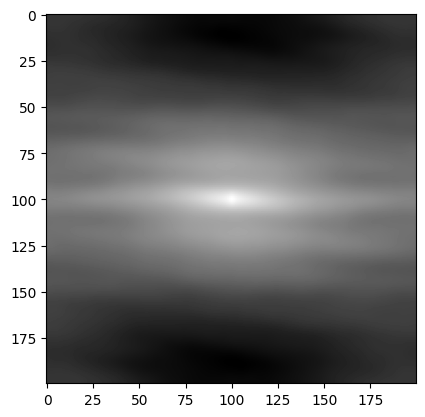

In [5]:

import numpy as np
import pickle
import scipy
from scipy.interpolate import interp1d
# import skimage
# from skimage import io, exposure, filters
from numpy.fft import fftshift, fft2, ifft2, fft, ifft
from numpy import real
from numpy import conj

aoto = autocorrelation_2D(img)
plt.imshow(aoto, cmap='gray')

In [6]:
T = []
for i in range(X.shape[0]):
    T.append(autocorrelation_2D(img))

T = np.array(T)

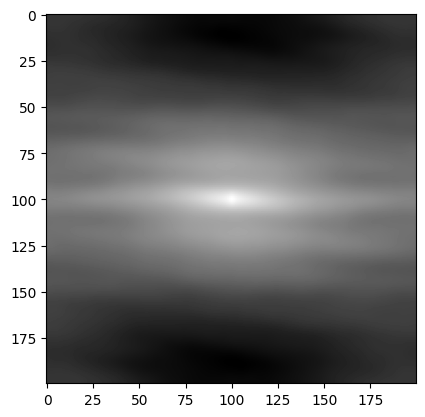

In [247]:
# plt.imshow(T[0],cmap='gray')

In [7]:
T[0].shape

(200, 200)

In [8]:
#单级小波分解，返回分别为低频分量，水平高频，竖直高频，对角高频，分别相当于上图中LL,HL,LH,HH
from pywt import dwt2,wavedec2

Z = []
for i in range(X.shape[0]):
    cA, (cH, cV, cD) = dwt2(X[i], 'db1')
#     cA2, (cH2, cV2, cD2), (cH1, cV1, cD1) = wavedec2(X[i], 'db1', level=2)
    Z.append((cH+cV+cD) / 3)
# plt.imshow(Z[2], cmap='gray')

In [9]:
Z = np.array(Z)
Z.shape
plt.imshow(Z[2], cmap='gray')

(250, 100, 100)

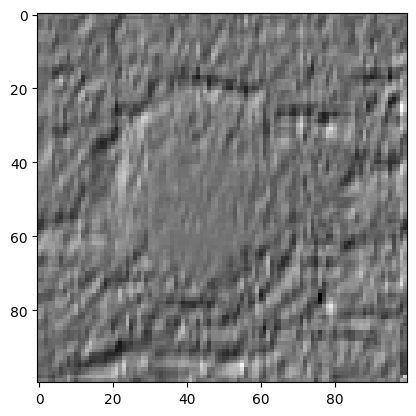

In [10]:
plt.imshow(Z[2], cmap='gray')

# 划分训练集测试集

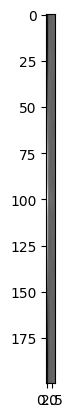

In [11]:
from sklearn.decomposition import PCA
pca = PCA(5)
P = []
# CON.reshape(-1,1)
for i in range(T.shape[0]):
    pca = pca.fit(T[i])
    P.append(pca.transform(T[i]))

P = np.array(P)
P.shape
plt.imshow(P[2], cmap='gray')

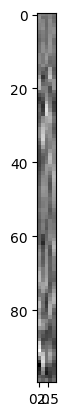

In [12]:
from sklearn.decomposition import PCA
pca = PCA(5)
S = []
# CON.reshape(-1,1)
for i in range(Z.shape[0]):
    pca = pca.fit(Z[i])
    S.append(pca.transform(Z[i]))

S = np.array(S)
S.shape
plt.imshow(S[2], cmap='gray')

In [13]:
S = S.reshape(len(S), -1)

P = P.reshape(len(P), -1)
print(P.shape)
print(S.shape)

(250, 1000)
(250, 500)


In [14]:
# 交叉验证+roc曲线
from sklearn import svm
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

In [15]:
# 交叉验证
cv = StratifiedKFold(n_splits=5)  # 导入该模型，后面将数据划分6份
classifier = svm.SVC(kernel='rbf', gamma=0.0001, C=1000, probability=True, random_state=0)  # SVC模型 可以换作AdaBoost模型试试

In [16]:
CON = []
CON = np.hstack((S,P))

In [17]:
CON.shape

(250, 1500)

In [18]:
CON = np.array(CON)
CON.shape

(250, 1500)

0.88
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        20
           1       0.88      0.93      0.90        30

    accuracy                           0.88        50
   macro avg       0.88      0.87      0.87        50
weighted avg       0.88      0.88      0.88        50

0.64
              precision    recall  f1-score   support

           0       1.00      0.10      0.18        20
           1       0.62      1.00      0.77        30

    accuracy                           0.64        50
   macro avg       0.81      0.55      0.48        50
weighted avg       0.78      0.64      0.53        50

0.66
              precision    recall  f1-score   support

           0       0.67      0.30      0.41        20
           1       0.66      0.90      0.76        30

    accuracy                           0.66        50
   macro avg       0.66      0.60      0.59        50
weighted avg       0.66      0.66      0.62        50

0.74

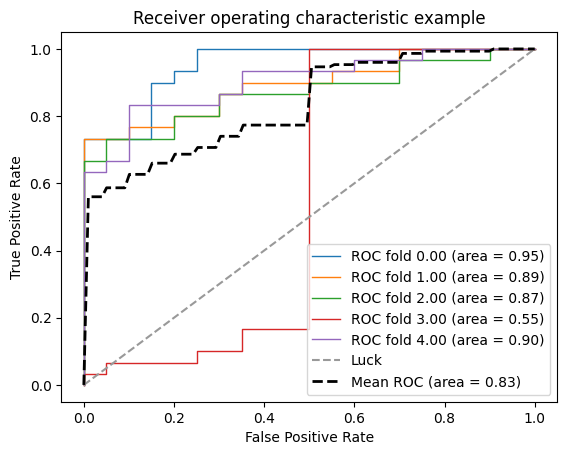

In [26]:
# 画平均ROC曲线的两个参数
mean_tpr1 = 0.0  # 用来记录画平均ROC曲线的信息
mean_fpr1 = np.linspace(0, 1, 100)
cnt = 0
for i, (train, test) in enumerate(cv.split(CON, Y)):  # 利用模型划分数据集和目标变量 为一一对应的下标
    cnt += 1
    probas_ = classifier.fit(CON[train], Y[train]).predict_proba(CON[test])  # 训练模型后预测每条样本得到两种结果的概率
    fpr, tpr, thresholds = roc_curve(Y[test], probas_[:, 1])  # 该函数得到伪正例、真正例、阈值，这里只使用前两个
    

    mean_tpr1 += np.interp(mean_fpr1, fpr, tpr)  # 插值函数 interp(x坐标,每次x增加距离,y坐标)  累计每次循环的总值后面求平均值
    mean_tpr1[0] = 0.0  # 将第一个真正例=0 以0为起点

    roc_auc = auc(fpr, tpr)  # 求auc面积
    plt.plot(fpr, tpr, lw=1, label='ROC fold {0:.2f} (area = {1:.2f})'.format(i, roc_auc))  # 画出当前分割数据的ROC曲线
    print(classifier.score(CON[test], Y[test])) 
    pre_y = classifier.predict(CON[test])
    pre_y = np.array(pre_y)
#     confusion_matrix = confusion_matrix(Y[test],pre_y)
#     print(confusion_matrix)
    print(classification_report(Y[test], pre_y))
    

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')  # 画对角线

mean_tpr1 /= cnt  # 求数组的平均值
mean_tpr1[-1] = 1.0  # 坐标最后一个点为（1,1）  以1为终点
mean_auc1 = auc(mean_fpr1, mean_tpr1)

plt.plot(mean_fpr1, mean_tpr1, 'k--', label='Mean ROC (area = {0:.2f})'.format(mean_auc1), lw=2)

plt.xlim([-0.05, 1.05])  # 设置x、y轴的上下限，设置宽一点，以免和边缘重合，可以更好的观察图像的整体
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')  # 可以使用中文，但需要导入一些库即字体
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()